#Edge Detection Algorithm from Scratch
For this assignment, I am implementing the canny edge detection algorithm. These are the steps involved:


1.   Grayscaling
2.   Gaussian Blurring
3.   Applying the sobel operator
4.   None-Max suppression
5.   Double Thresholding
6.   Hysterisis

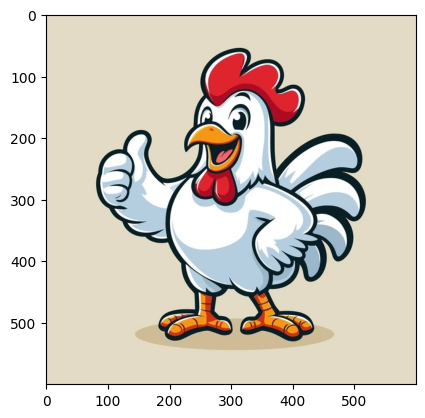

In [29]:
import numpy as np
from scipy.ndimage import convolve
from PIL import Image
from matplotlib.pyplot import imshow

PATH = "/content/cartoon-chickenmascot-logo-illustration-600nw-2494360959.webp"
image = Image.open(PATH)
np_img = np.array(image)

imshow(np_img)

##GrayScaling the image
For Grayscaling, I'll use the same formula used by *OpenCV*:  

Y = 0.299 · R + 0.587 · G + 0.114 · B    

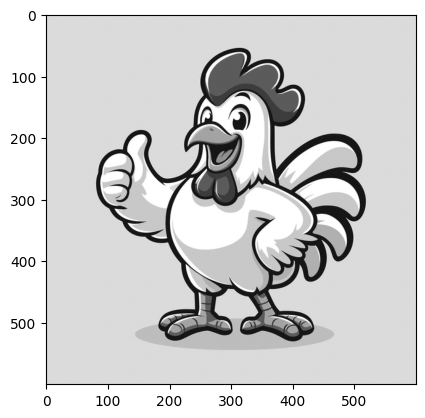

In [30]:
R = np_img[:,:,0]
G = np_img[:,:,1]
B = np_img[:,:,2]

gray_img = 0.299 * R + 0.587 * G + 0.114 * B

imshow(gray_img, cmap='gray')

#Gaussian Blur/Smoothening
In this case I'll use a 5x5 kernel to do the smoothening. The gaussian_kernel() function returns the gaussian kernel.  
Using it we'll perform convolution on the kernel. Turns out the numpy convolve function is only meant for 1D arrays. So we'll import the scipy convolve function.

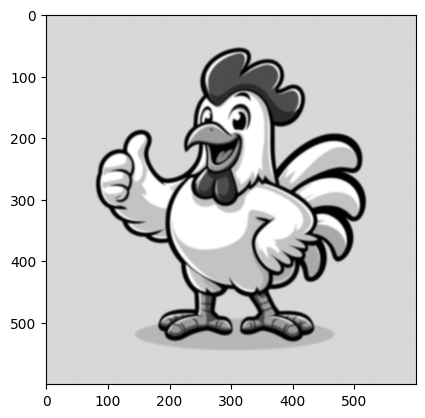

In [31]:
def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2) / (2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)  # normalizing

kernel = gaussian_kernel(5, 1.4)
smoothed_img = convolve(gray_img, kernel)

imshow(smoothed_img, cmap='gray')

##Applying the sobel operator and finding the gradients
We will apply both the Sobel X and Y kernels. Then We'll compute the gradients and direction.

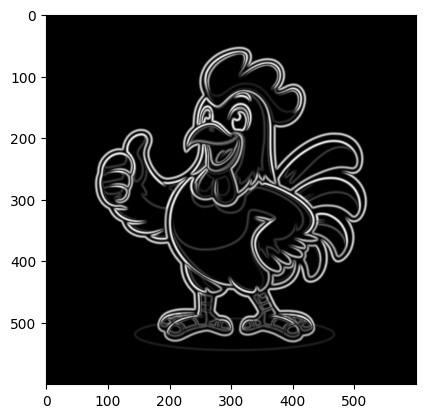

In [32]:
Kx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]], dtype=np.float32)

Ky = np.array([[-1, -2, -1],
               [0, 0, 0],
               [1, 2, 1]], dtype=np.float32)

Ix = convolve(smoothed_img, Kx)
Iy = convolve(smoothed_img, Ky)

#Hypot finds the "hypotenuse"
G = np.hypot(Ix, Iy)
G = G / G.max() * 255 #Normalising in the range 0-255
theta = np.arctan2(Iy, Ix)

imshow(G, cmap='gray')

We can actually even stop here (maybe apply some noise suppression to it).  
But there are few more steps particular to Canny-Edge detection algorithm.

##None-Maximum Suppression
The crucial step in Canny Edge detection. We look for pixels in the direction of the edge(we'll find the direction using `theta`). If it's gradient strength is less then those in adjacent pixel, we suppress it.  
We classify `theta` into 8 directions because each pixel is surrounded by 8 pixels.  
The motivation behind None-Maximum suppression is to keep only the "local maxium" and discard all the weak edges.

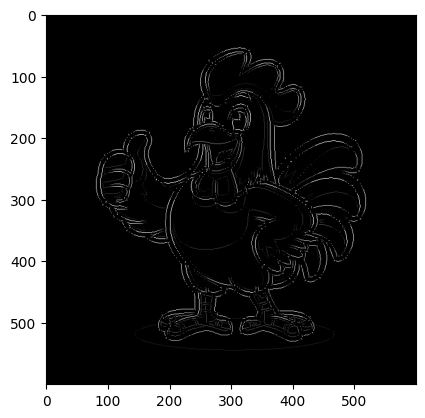

In [33]:
m, n = G.shape
supp_img = np.zeros_like(G, dtype=np.float32)
angle = theta * 180. / np.pi
angle[angle < 0] += 180

for i in range(1, m-1):
    for j in range(1, n-1):
      a = 255
      b = 255

      if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
        a = G[i,j+1]
        b = G[i,j-1]
      elif (22.5 <= angle[i, j] < 67.5):
        a = G[i+1,j-1]
        b = G[i-1,j+1]
      elif (67.5 <= angle[i, j] < 112.5):
        a = G[i+1, j]
        b = G[i-1, j]
      elif (112.5 <= angle[i, j] < 157.5):
        a = G[i-1, j-1]
        b = G[i+1, j+1]

      if (G[i, j] >= a) and (G[i, j] >= b):
        supp_img[i, j] = G[i, j]
      else:
        supp_img[i, j] = 0
supp_img = supp_img.astype(np.uint8)

imshow(supp_img, cmap='gray')

##Double Thresholding
This is normal noise suppression. I'll set all pixels over a certain threshold(Th) as 255(Max Value) and all below the other threshold (Tl) as 0

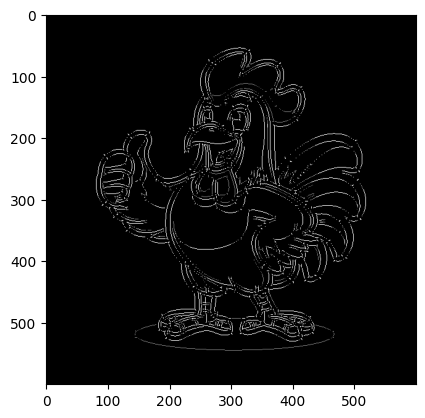

In [34]:
Tl = 10
Th = 100
supp_img[supp_img >= Th] = 255
supp_img[(supp_img >= Tl) & (supp_img < Th)] = 128
supp_img[supp_img < Tl] = 0

imshow(supp_img, cmap='gray')
#

#Hysterisis
If a pixel is close to an edge, set it as 255. Otherwise make it 0.

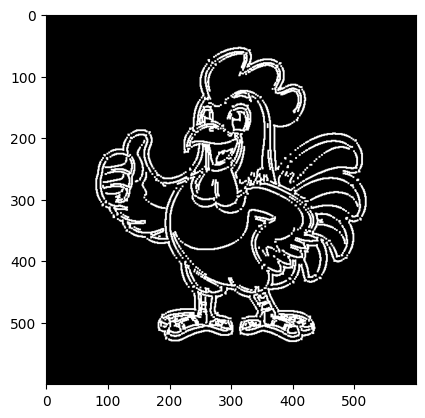

In [35]:
m, n = supp_img.shape
canny_image = np.zeros((m, n), dtype=np.uint8)

for i in range(1, m-1):
  for j in range(1, n-1):
    for k in range(i-1, i+2):
      to_break = False
      for l in range(j-1, j+2):
        if supp_img[k, l] == 255:
          canny_image[i, j] = 255
          to_break = True
          break
      if to_break:
          break

imshow(canny_image, cmap='gray')